In [1]:
import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt

import torch, numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Generate a dataset of signals and binary labels 

In [3]:
class SyntheticSignals():
    def __init__(self, A, B, n, m, s, s_sigma = 0.5, eps_sigma = 0.01, size = 1000, batch_size = 400):
        
        self.n = n          # Number of samples in the original signal
        self.m = m          # Number of samples through the linear transformation

        self.size = size    # Size of the dataset

        self.alpha = torch.zeros(self.size, self.n)          # Underlying sparse vector 
        self.x = torch.zeros(self.size, self.m)              # Observation
        self.y = torch.zeros(self.size)                     # Binary label 

        self.A = A          # Matrix for the linear observation - Label 0
        self.B = B          # Matrix for the linear observation - Label 1
        self.s = s          # Sparsity of the signal

        self.s_sigma = s_sigma
        self.eps_sigma = eps_sigma

        self.batch_size = batch_size

        # Generating the dataset
        self.set_data()


    def set_tuple(self, i):

        # Generating random sparsity in the canonic basis of the original signal
        idxs = np.random.choice(self.m, self.s, replace=False)
        peaks = np.random.normal(scale=self.s_sigma, size = self.s)
        y_ = np.random.choice([0,1])
        
        # Generating the original signal and its corrupted observations according to a label
        self.alpha[i, idxs] = torch.from_numpy(peaks).to(self.alpha)
        self.x[i,:] = (self.A * (y_ == 1) + self.B * (y_ == 0)) @ self.alpha[i,:] + np.random.normal(scale=self.eps_sigma, size=self.m)
        self.y[i] = y_

    def set_data(self):
        for i in range(self.size):
            self.set_tuple(i)
    
    
    def set_loader(self):

        # We need tuples observation/label
        return Data.DataLoader(dataset = Data.TensorDataset(self.x, self.y),
                               batch_size = self.batch_size,
                               shuffle = True)

___________________

### Model definition

In [54]:
class TDDL(nn.Module):
    def __init__(self, 
                 M, 
                 P, 
                 K, 
                 Lambda = 0.15, 
                 T = 100, 
                 t_0 = 1, 
                 LR = 5e-03):
        
        super().__init__()

        # Dictionary initialization 
        self.D = self.projD(torch.randn((M, P)))

        # Assumed sparsity
        self.K = K

        # Hyperparameters
        self.Lambda = Lambda
        self.t_0 = t_0
        self.T = T
        self.LR = LR

        # Define the linear model W
        self.fc1 = nn.Linear(P, 1)

        # Define the optimization utilities 
        self.criterion = nn.BCELoss()  

        # Loss tracker
        self.losses = []

    def initialization(self):
        pass
    
    def forward(self, alpha):
        return torch.sigmoid(self.fc1(alpha))

    def OMP(self, X):
        batch_size = X.shape[0]
        S = [[] for _ in range(batch_size)]
        alpha = torch.zeros((batch_size, self.D.shape[1]), device=X.device)
        R = X.clone()
        
        for _ in range(self.K):
            correlations = torch.matmul(R, self.D)
            selected_atoms = torch.argmax(torch.abs(correlations), dim=1)
            
            for i in range(batch_size):
                S[i].append(selected_atoms[i].item())
                dic = self.D[:, S[i]]
                x_S = torch.linalg.inv(dic.t() @ dic) @ dic.t() @ X[i]
                alpha[i, S[i]] = x_S
                R[i] = X[i] - torch.matmul(self.D, alpha[i])
        
        return torch.tensor(alpha, requires_grad=True)

    def activeSet(self, alpha):
        return torch.nonzero(alpha, as_tuple=True)

    def projD(self, D):
        
        # We constrain the atoms to have norm at most equal to one
        def projCol(d):
            return d / torch.max(torch.tensor(1.0, device=d.device), torch.linalg.norm(d))
        return torch.stack([projCol(D[:, i]) for i in range(D.shape[1])], dim=1)
    
    def update(self, X, Y):
        # Compute the sparse approximation and its non-zero entries set
        alpha = self.OMP(X)
        L = self.activeSet(alpha)

        # Forward this sparse feature vector enabling gradient computation with respect to the sparse vector
        y_hat = self.forward(alpha)

        # Loss computation and backpropagation
        loss = self.criterion(y_hat[:,0], Y)
        loss.backward()

        # Define the auxiliary vector for the D-gradient computation 
        beta = torch.zeros_like(alpha)
        for i in range(alpha.shape[0]):
            active_indices = L[1][L[0] == i]
            dic = self.D[:, active_indices]
            beta[i, active_indices] = torch.matmul(torch.linalg.inv(torch.matmul(dic.t(), dic)), alpha.grad[i, active_indices])

        ##########################
        ### OPTIMIZATION PHASE ###
        ##########################

        # Gradient descent for the model parameters update
        with torch.no_grad():
            for param in self.parameters():
                param -= self.LR * param.grad

        # Projected gradient descent for the dictionary update
        with torch.no_grad():
            grad_D = - self.D @ torch.matmul(beta.t(), alpha) + torch.matmul((X - torch.matmul(alpha, self.D.t())).t(), beta)
            self.D = self.projD(self.D - self.LR * grad_D)
            
        # Loss tracking
        self.losses.append(loss.item())

    def trainLoop(self, train_loader):
        
        # Set to train mode
        self.train()

        # Main loop
        for t in tqdm(range(self.T)):
            for X, Y in train_loader:
                self.update(X, Y)    

    def reset(self):
        self.losses = []

In [55]:
# Dimensions for the signal, its sparsity and its observation

m_ = 150
n_ = 200
s_ = 20

# Measurement matrices
A_ = torch.randn(m_,n_)
A_ /= torch.norm(A_, dim=0)

B_ = torch.randn(m_,n_)
B_ /= torch.norm(A_, dim=0)

# Building a training set and a test set 
train_set = SyntheticSignals(A = A_,
                             B = B_,
                             n = n_,
                             m = m_,
                             s = s_,
                             size = 800).set_loader()

test_set = SyntheticSignals(A = A_,
                            B = B_,
                            n = n_,
                            m = m_,
                            s = s_,
                            size = 200).set_loader()

In [56]:
model = TDDL(m_, n_, 20, T = 100, LR = 5e-3)

In [57]:
model.D

tensor([[-0.0300,  0.0152,  0.1685,  ..., -0.1502, -0.1556, -0.0384],
        [ 0.0608,  0.0238, -0.1000,  ..., -0.1714, -0.0369, -0.0947],
        [ 0.0431,  0.1353,  0.0604,  ...,  0.0594, -0.0422,  0.0361],
        ...,
        [ 0.0173,  0.1404, -0.0784,  ..., -0.0126,  0.0095,  0.0041],
        [-0.0765, -0.0076,  0.0469,  ...,  0.1045,  0.0214,  0.0396],
        [ 0.0516,  0.0150, -0.0325,  ...,  0.1004, -0.0217, -0.0070]])

In [ ]:
model.trainLoop(train_set)

In [44]:
model.D

tensor([[ 0.1272,  0.0472,  0.0423,  ..., -0.0694,  0.0358, -0.0858],
        [-0.0632,  0.0544,  0.0349,  ...,  0.0122, -0.0085, -0.1927],
        [-0.0163,  0.0936, -0.0763,  ...,  0.0462,  0.0753,  0.0323],
        ...,
        [ 0.0298,  0.0917,  0.1917,  ..., -0.0162, -0.0696,  0.0746],
        [ 0.0760, -0.0491, -0.1018,  ..., -0.0142,  0.0282,  0.1367],
        [-0.0567,  0.0391, -0.1147,  ...,  0.0047,  0.0255,  0.1404]])

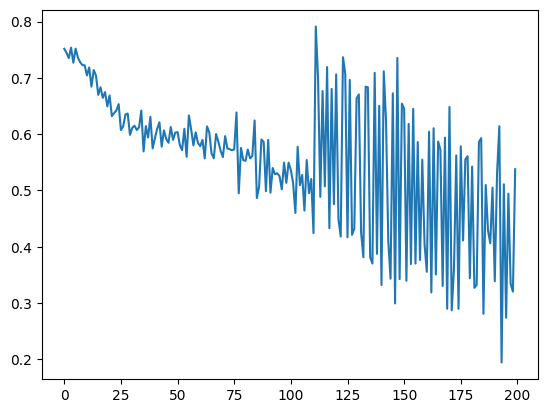

In [45]:
plt.plot(model.losses)